# Social Media Analyzer (Reddit Echo Chamber)
## by Alisha Tajin

### GOAL: A Python tool that analyzes reddit posts (posts, or comments) to measure ideological diversity and identify echo chamber effects using natural language processing and clustering.

In [2]:
import sys
!{sys.executable} -m pip install pandas nltk textblob langdetect


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: /opt/miniconda3/bin/python -m pip install --upgrade pip


In [3]:
import pandas
import nltk
import textblob
import langdetect
print("Packages installed correctly!")


Packages installed correctly!


In [4]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tajinali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
import pandas as pd
import re
from langdetect import detect
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tajinali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
#adding the dataset
df = pd.read_csv("../data/the-reddit-dataset-comments.csv")
df.head()


,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score
0,comment,hyyz6g8,2r97t,datasets,False,1646173750,https://old.reddit.com/r/datasets/comments/t45...,Spatial problem: Suitability of new locations ...,0.0772,1
1,comment,hyyid7v,2r97t,datasets,False,1646167280,https://old.reddit.com/r/datasets/comments/sg9...,Have you tried toying around with GDELT or Ali...,0.0000,2
2,comment,hyxp1qp,2r97t,datasets,False,1646156018,https://old.reddit.com/r/datasets/comments/t44...,Damn random internet person of whom I know not...,-0.3851,3
3,comment,hyxgnyu,2r97t,datasets,False,1646152782,https://old.reddit.com/r/datasets/comments/t44...,Ah nice one. Best of luck with the baby. If yo...,0.9136,3
4,comment,hyxfjw6,2r97t,datasets,False,1646152345,https://old.reddit.com/r/datasets/comments/t49...,I was about to write and say this shouldn't be...,0.0762,2


In [28]:
#narrowing the columns down
df.columns = df.columns.str.strip()
df = df[["body", "score"]].dropna()

df.columns = ["text", "engagement"]

# Sample 60 posts for analysis
df = df.sample(n=60, random_state=42).reset_index(drop=True)
df.head()


,text,engagement
0,My 10 years worth - thousands of comments. Con...,1
1,"Late to the party, but like everyone else said...",2
2,The problem is most of the aggregated data isn...,1
3,Yahoo and Google are pretty solid. Other optio...,2
4,following,2


In [29]:
# CLEANING THE DATA: 
# Raw social media text often contains URLs, special characters, and formatting noise that can interfere with natural language processing. 
# To address this, each post was cleaned by: Removing URLs, removing non-alphabetic characters, and standardizing text format

STOP_WORDS = set(stopwords.words('english'))

def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.strip()

def count_lines(text):
    return len(text.split("\n"))

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

def assign_tags(text):
    text = text.lower()
    tags = []

    if any(word in text for word in ["ai", "machine learning", "automation"]):
        tags.append("#AI")
    if any(word in text for word in ["leader", "management", "team"]):
        tags.append("#Leadership")
    if any(word in text for word in ["climate", "environment"]):
        tags.append("#Climate")
    if any(word in text for word in ["government", "policy", "election"]):
        tags.append("#Politics")
    if any(word in text for word in ["work", "career", "job"]):
        tags.append("#Career")

    return ", ".join(tags[:2]) if tags else "#General"

def classify_tone(text):
    polarity = TextBlob(text).sentiment.polarity

    if polarity > 0.3:
        return "Optimistic"
    elif polarity < -0.3:
        return "Critical"
    elif any(word in text.lower() for word in ["please", "thank", "appreciate"]):
        return "Respectful"
    elif len(text.split()) > 20:
        return "Formal"
    else:
        return "Casual"


In [30]:
#To enrich the dataset beyond raw text, several additional features were engineered:
# Engagement: Retained from Reddit score to capture audience interaction
# Line count: Calculated to reflect post structure and verbosity
# Language: Automatically detected to ensure text consistency and enable filtering
# Tags: Assigned using keyword-based heuristics to identify major discussion themes
# Tone: Classified into one of five categories (Casual, Formal, Optimistic, Critical, Respectful) using sentiment analysis and linguistic rules
# These features transform unstructured text into structured data suitable for analysis.


df["text"] = df["text"].apply(clean_text)
df["line_count"] = df["text"].apply(count_lines)
df["language"] = df["text"].apply(detect_language)
df["tags"] = df["text"].apply(assign_tags)
df["tone"] = df["text"].apply(classify_tone)

df.head()


,text,engagement,line_count,language,tags,tone
0,My years worth thousands of comments Conside...,1,5,en,#General,Respectful
1,Late to the party but like everyone else said ...,2,1,en,#AI,Formal
2,The problem is most of the aggregated data isn...,1,1,en,#General,Optimistic
3,Yahoo and Google are pretty solid Other option...,2,1,en,#General,Casual
4,following,2,1,en,#General,Casual


In [31]:
# Adding it to the echo-chambered analysis: The enriched dataset was designed to support echo chamber detection by enabling:
# - Clustering based on textual similarity
# - Comparison of engagement across ideological groups
# - Analysis of tone distribution within clusters

df.to_csv("../data/reddit_enriched_posts.csv", index=False)
print("Saved reddit_enriched_posts.csv")


Saved reddit_enriched_posts.csv


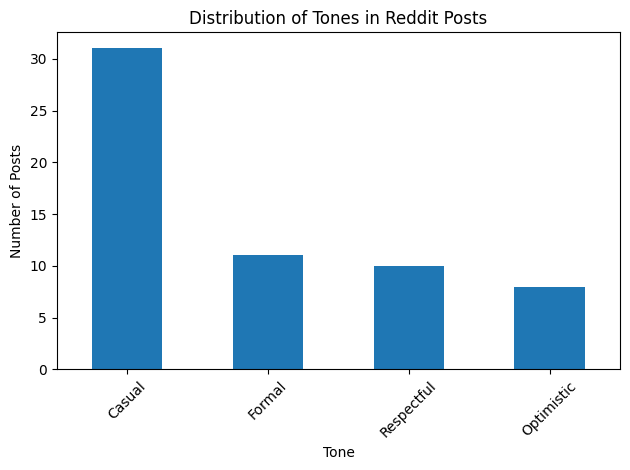

In [32]:
# Graphing: What is the dominant tone of Reddit discourse in this new enriched dataset?
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/reddit_enriched_posts.csv")
df.head()

tone_counts = df["tone"].value_counts()
tone_counts

plt.figure()
tone_counts.plot(kind="bar")
plt.title("Distribution of Tones in Reddit Posts")
plt.xlabel("Tone")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Making an Echo-Chamber Scatter Plot Analysis

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [38]:
df = pd.read_csv("reddit_enriched_posts.csv")
df.head()


,text,engagement,line_count,language,tags,tone
0,Spatial problem Suitability of new locations f...,1,1,en,#AI,Optimistic
1,Have you tried toying around with GDELT or Ali...,2,1,en,#General,Casual
2,Damn random internet person of whom I know not...,3,5,en,"#AI, #Career",Respectful
3,Ah nice one Best of luck with the baby If you ...,3,1,en,#General,Optimistic
4,I was about to write and say this shouldnt be ...,2,1,en,#General,Formal


In [47]:
# for np.nan values:
df = df.dropna(subset=["text"])
df = df[df["text"].str.strip() != ""]

#TF-IDF Vectorization: It highlights words that define viewpoints while downweighting common language.
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=500
)

X = vectorizer.fit_transform(df["text"])


In [46]:
# KMeans Clustering, 3 clusters because we want the data to be small enough to interpret but large enough to capture separation.

NUM_CLUSTERS = 3

kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
df["cluster"] = kmeans.fit_predict(X)


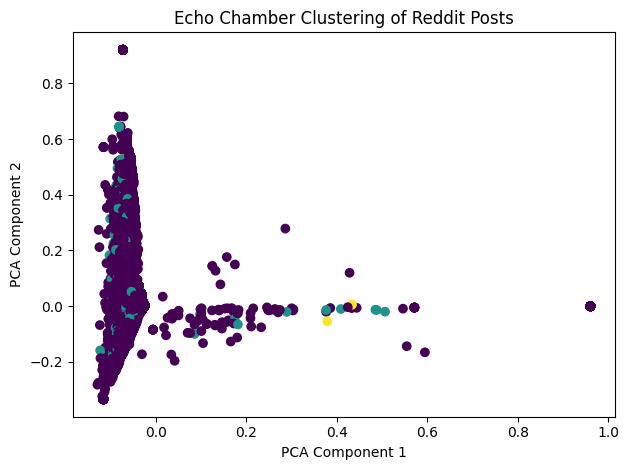

In [45]:
# Visualize Clusters (PCA)

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

plt.figure()
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=df["cluster"]
)
plt.title("Echo Chamber Clustering of Reddit Posts")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [44]:
# based on this echo chamber we also try to define a simple, explainable metric (the score)
num_posts = len(df)
num_clusters_used = df["cluster"].nunique()

echo_chamber_score = 1 - (num_clusters_used / num_posts)

print(f"Echo Chamber Score: {echo_chamber_score:.2f}")


Echo Chamber Score: 1.00
